<h1> <center> Estra: Clustering Methods for Astrophysical Data Visualization in the Moon-forming Synestia Simulation  </center> </h1>

*$\texttt{Estra}$ utilizes machine-learning clustering and dimensionality-reduction techniques to automate, inform, and improve astrophysical visualization in Houdini, one of the premiere tools for visualizing large, complex data.*

*$\texttt{Estra}$ loads the simulation datasets used in for visualization, finds physically-interpretable clusters, and feeds useful cluster results into Houdini pythonically to help generate viz shader networks for renderring.*

<h2> 1. Preparing the simulation for import  </h2>

First we import the necessary libraries for analysis and visuals:

In [2]:
# for analysis
import pandas as pd
import numpy as np
import scipy

#for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set(font_scale=1.2)
np.set_printoptions(suppress=True, threshold=np.nan)
plt.subplots(figsize=(20, 10))

%matplotlib inline

From Section 2.1 in the corresponding paper, follow the instructions to prepare the simulation as a .csv file for import. Once in a .csv format, use the pandas library to import this file as a dataframe:

In [2]:
#import synestia particle attribute data
#this data is static, and after extra radiation cooling has been added post simulation

particles = pd.read_csv('synestia_particle_data.csv') #make sure the path-to-file is correct
particles.head() #confirm the data looks correct, akin to the "Geometry Spreadsheet" tab in Houdini

,id,pressure,temperature,density,P[X],P[Y],P[Z],vel[X],vel[Y],vel[Z],mass,entropy,smoothLen,potential
0,1,225.657486,7361.239746,12.123034,-1.035675,1.451132,-0.113785,-3.700542,-2.632296,0.058064,5.920000e+22,17429698,0.488643,-1.000000e+12
1,2,250.719452,6967.509277,12.465510,-0.587094,0.996217,-0.057019,-2.539360,-1.497492,0.003513,5.920000e+22,17042952,0.487478,-1.030000e+12
2,3,227.593506,6996.430176,12.177461,-0.987687,1.308719,0.388076,-3.347536,-2.529887,0.017951,5.920000e+22,17179808,0.487963,-1.000000e+12
3,4,252.776413,6860.425781,12.498366,-0.053954,1.197015,0.250453,-3.047109,-0.119876,0.055459,5.920000e+22,16965152,0.487663,-1.020000e+12
4,5,245.270584,7354.320313,12.370044,-0.504045,1.371142,0.366814,-3.539281,-1.287469,-0.008884,5.920000e+22,17318536,0.487871,-1.010000e+12


<h2> 2. Preprocessing the data for clustering  </h2>

Next we impose some thresholds on the simulation data. This example comes from *a priori* knowledge of simplifying the data in the context of its visualization-- this step may be skipped and either informed later or ignored altogether, depending on the simulation.

Here, there is thresholding of two attibutes: 
+ "smoothLen", or *smoothing length* of the particles 
+ "density", the aptly-named *density* of the particles 

At very high *smoothLen* values, the sphere sprites of the particles become too large, and subsequently dominate the visualization when in reality they are on the outer fringes, and not the key components (core, mantle, etc.) we are trying to show.

For this same reason we impose an upper-limit density cutoff as to be computationally efficient; because the most dense particles are within the core, rendering these particles becomes superflous when there are already many other very dense particles consituting it.

In [3]:
#Smoothing length threshold
hsml_upbound = particles[particles["smoothLen"] <= 90]

#Density threshold
particles_bounded = hsml_upbound[hsml_upbound["density"] <= 3.4] #max inside core (from shader)
print(particles_bounded)

               id   pressure   temperature   density       P[X]       P[Y]  \
36671   200000000   0.998479   7480.469238  0.642256  -0.472065  -8.650381   
36672   200000000  12.245077   8193.594727  3.101000  -3.811483  -5.744662   
36673   200000000   2.205342   8865.547852  0.980643  -3.705107  -2.498674   
36674   200000000   9.998915   8511.694336  2.984475   2.475773  -6.797088   
36675   200000000   4.861516   8811.471680  2.597961  -6.288623   0.374799   
36676   200000000   7.609941   8405.995117  2.879080  -5.165038  -5.097959   
36677   200000016   0.352076   6808.496094  0.228650   8.047278   5.478495   
36678   200000016   3.907097   8763.194336  2.482572   0.984196   6.970543   
36679   200000016   0.036041   6461.284668  0.019096 -10.037862   9.104488   
36681   200000016   0.842821   7677.710449  0.454823   7.492118  -2.812991   
36682   200000016  16.995773   7166.801758  3.303640   1.967836  -6.002256   
36684   200000016   2.988850   9100.246094  1.827929   5.402254 

<h4> Restricting the dimensionality of the data </h4>

Because many clustering algorithms have difficulty in large dimensional-space (i.e. k-means, as it has it compute Euclidean distance measurements), we need to limit the dimensionality of the dataset. This can be done in two ways, the preference of which is up to the user, depending on the dataset:

> A) Use dimensionality-reduction techniques such as Principal Component Analysis (PCA), Non-negative matrix factorization, t-distributed stochastic embedding (t-SNE), etc., and find the few compnents that retain most of the variance in the high demensional dataset.

> B) Drop the rest of the data, and only focus on two attributes at a time.

<h2> 2A. Dimensionality-reduction algorithms  </h2>

Dimensionality reduction techniques can be utilized to take into account the $n$-dimensional attribute space by visualizing several attributes at once, instead of arbitrarily only picking one or two for visualization and throwing the rest out...

<h2> 2B. Drop-dimensions method  </h2>

The alternative method, simply dropping unused variables/attributes for all particles, is the most-used technique for viz artists. They, in communication with the scientist who created the simulation, will focus visualizing only the most important variables (as a function of time, if time-evolving). Thus, the resulting clustering methods will work, but going forward the algorithms will not "know" about the other data available.

In the following, we create four grouping of two variables, as some collections of variables in that particular phase-space will be more easily clustered compared to others:

+ Temperature & Pressure
+ Temperature & Density
+ Temperature & Entropy
+ Pressure & Entropy

Temperature is rather crucial as we will use temperature values from the clustering results to inform an emissive color map to be used in the shader.

In [4]:
temp_and_pressure = particles_bounded.drop(['id', 'density', 'P[X]', 'P[Y]', 'P[Z]', 'vel[X]', 'vel[Y]', 'vel[Z]', 
                                            'mass', 'entropy', 'smoothLen', 'potential'], axis=1)
temp_and_density = particles_bounded.drop(['id', 'pressure', 'P[X]', 'P[Y]', 'P[Z]', 'vel[X]', 'vel[Y]', 'vel[Z]', 
                                            'mass', 'entropy', 'smoothLen', 'potential'], axis=1)
temp_and_ent = particles_bounded.drop(['id', 'pressure', 'P[X]', 'P[Y]', 'P[Z]', 'vel[X]', 'vel[Y]', 'vel[Z]', 
                                            'mass', 'density', 'smoothLen', 'potential'], axis=1)
pressure_and_ent = particles_bounded.drop(['id', 'density', 'temperature', 'P[X]', 'P[Y]', 'P[Z]', 'vel[X]', 'vel[Y]', 'vel[Z]', 
                                            'mass', 'smoothLen', 'potential'], axis=1)
temp_and_ent.head()

,temperature,entropy
36671,7480.469238,58827208
36672,8193.594727,48131536
36673,8865.547852,58265784
36674,8511.694336,48869084
36675,8811.471680,50395076


<h2> 3. Apply clustering algorithms. Find the bounding box and mean values for each cluster  </h2>

With the preprocessing done, we can begin testing several clustering algorithms, keeping in mind that we are in search of "physically-interpretable" clusters; that is, clusters that correspond to real physical structures within the physical system proper, and not arbitrary, non-physically meaningful mathematical curiosities.

Before we begin, we need to scale our attribute values, as some ML algorithms are biased towards larger or smaller quantities. This is because many ML algorithms assume that all attributes are centered about zero and have the same order variance. Thus, if a particular attribute has a variance several orders of magnitude larger than another, it might dominate the objective function and disable the estimator learning from the other attributes available in the correct way. 

In the units of this synestia simulation, temperature ($O(1000)$) is four orders of magnitude smaller than the given entropy values ($O(10000000)$). And so, we implement the *StandardScaler* package from the *sklearn.preprocessing* module:

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 

For this notebook example, we will cluster in a temperature-entropy phase space:

> <h3> Temperature & Entropy </h3>

<h3> K-means, Mini-batch K-means  </h3>

The first of many unsupervised clustering algorithms available to use in $\texttt{Estra}$ is K-means, through the *sklearn.cluster* module. 
Its documentation is found here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. 

Likewise, the mini-batch counterpart documentation is here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans.

Note that k-means, mini-batch k-means may converge to a local optimum. Run several times for most robust result. Also, the colors are not linked to the same cluster for each iteration, only that they represent different clusters. In both methods the number of clusters is chosen by the user, so it is best know beforehand how many physical clusters one should expect to have a starting point.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


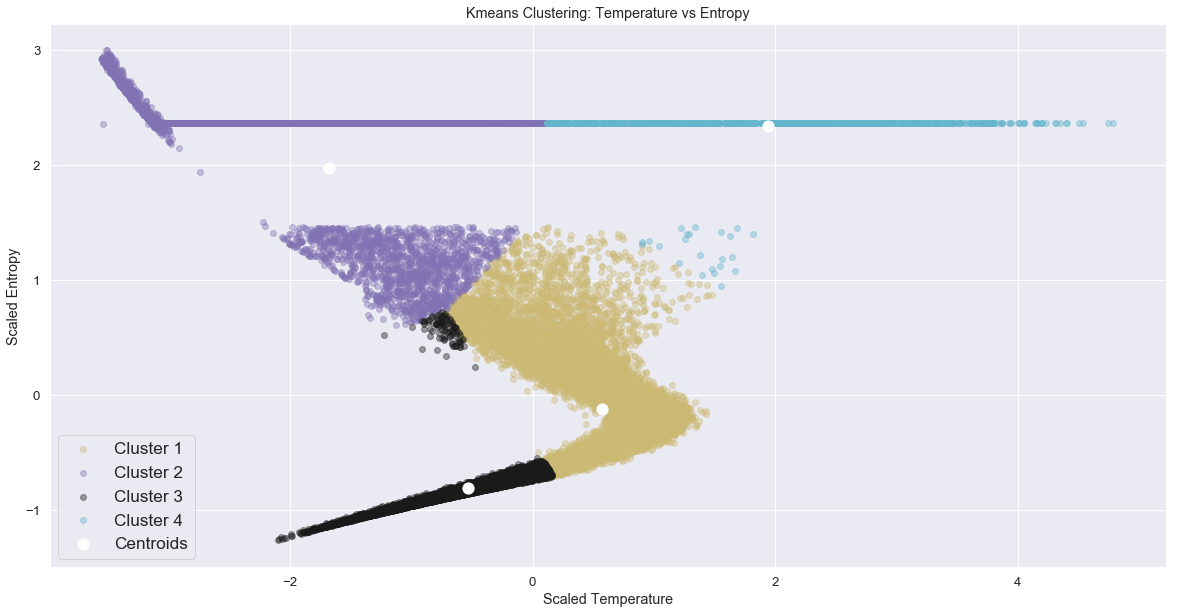

In [6]:
#for K-means clustering

from sklearn.cluster import KMeans 
plt.subplots(figsize=(20, 10)) #Make figure size reasonable

# Load our data and find the standard score
X = temp_and_ent
X = scaler.fit_transform(X)

# Create our K-means method
kmeans = KMeans(n_clusters=4, #specifies 4 clusters
                init='k-means++', #selects initial cluster centers intelligently
                max_iter=300, #max number of iterations of single run
                n_init=50, #number of times to be run w/ different centriod seeding
                random_state=42) #Use a new random number generator seeded by 42
kmeans.fit_predict(X) # Applying k-means clustering
centroids = kmeans.cluster_centers_ #Coordinates of cluster centers with shape [n_clusters, n_features]
labels = kmeans.labels_ #Labels of each point to distinguish cluster membership

unique_clusters = np.unique(labels) #find the unique cluster membership labels
colors = ['y','m','k','c'] #will assign a color per cluster

#For each cluster membership label, plot all SPH particles and centriods. Distinguish with different colors
for i, j in enumerate(unique_clusters):
    xi = [X[:,0][k] for k in range(len(X)) if labels[k] == j] 
    yi = [X[:,1][k] for k in range(len(X)) if labels[k] == j]
    plt.scatter(xi, yi, s=35, c=colors[i], alpha=0.4, label='Cluster '+ str(j+1)) 
plt.scatter(centroids[:,0], centroids[:,1], s=125, marker='o', c=['white'], alpha=1.0, label='Centroids')

#Plot!
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel("Scaled Temperature")
plt.ylabel("Scaled Entropy")
plt.title('Kmeans Clustering: Temperature vs Entropy')
plt.show()

In [7]:
print('\033[1m' "K-means \n" '\033[0m')
print("In original (unscaled) ||| scaled units for [Temperature Entropy]: \n")

cluster_num = ["first", "second", "third", "fourth"] #make sure this corresponds to n_clusters

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(kmeans.n_clusters) ):
    clus_cluster_scaled = np.array(X[np.where(kmeans.labels_ == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    
    #Find size, bounding box, mean values
    print(clus ,"cluster size count:", len(clus_cluster))
    print(clus ,"cluster lower bound:", clus_cluster.min(axis=0), "||| scaled:", clus_cluster_scaled.min(axis=0))
    print(clus ,"cluster mean:", clus_cluster.mean(axis=0), "||| scaled:", clus_cluster_scaled.mean(axis=0))
    print(clus ,"cluster upper bound:", clus_cluster.max(axis=0), "||| scaled:", clus_cluster_scaled.max(axis=0))
    
    #Centriod stats for each cluster
    clus_centriod_scaled = kmeans.cluster_centers_[i]
    clus_centriod = scaler.inverse_transform(kmeans.cluster_centers_[i])
    print(clus ,"cluster centriod loc:", clus_centriod, "||| scaled:", clus_centriod_scaled, "\n")

K-means 

In original (unscaled) ||| scaled units for [Temperature Entropy]: 

first cluster size count: 18905
first cluster lower bound: [    7085.082031 47548960.      ] ||| scaled: [-0.7121364  -0.70384961]
first cluster mean: [    8767.52615083 52917403.58635282] ||| scaled: [ 0.56836894 -0.12038988]
first cluster upper bound: [    9962.017578 67483648.      ] ||| scaled: [1.47749432 1.46271644]
first cluster centriod loc: [    8767.7997383 52916383.4952648] ||| scaled: [ 0.56857717 -0.12050075] 

second cluster size count: 4246
second cluster lower bound: [    3349.891357 59667980.      ] ||| scaled: [-3.55498364  0.61328449]
second cluster mean: [    5816.55977088 72184464.30711257] ||| scaled: [-1.67760653  1.97361629]
second cluster upper bound: [    8165.394043 81670136.      ] ||| scaled: [0.11008722 3.00454961]
second cluster centriod loc: [    5817.22383627 72179694.38700609] ||| scaled: [-1.67710111  1.97309788] 

third cluster size count: 10696
third cluster lower bound: 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


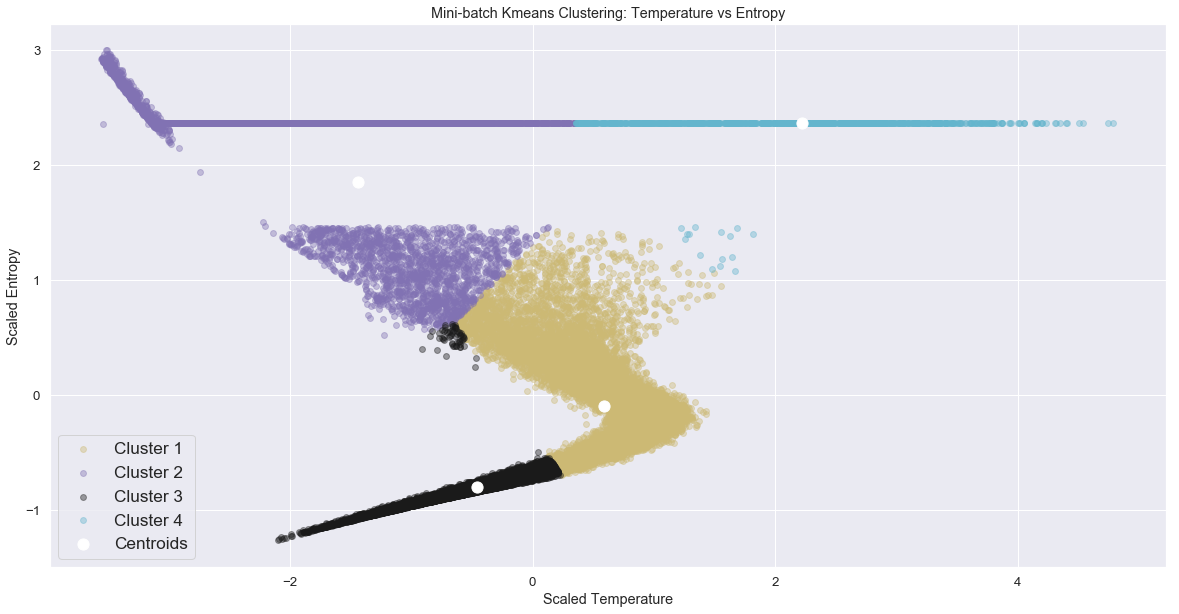

In [8]:
#for Mini-batch K-means clustering

from sklearn.cluster import MiniBatchKMeans
plt.subplots(figsize=(20, 10)) #Make figure size reasonable

# Load our data and find the standard score
X = temp_and_ent
X = scaler.fit_transform(X)

# Create our mini-batch k-means method
minibatchkmeans = MiniBatchKMeans(n_clusters=4, #specify 4 clusters
                                  init='k-means++', #selects initial cluster centers intelligently
                                  max_iter=300, #max number of iterations of single run
                                  n_init=50, #number of times to be run w/ different centriod seeding
                                  random_state=42) #Use a new random number generator seeded by 42
minibatchkmeans.fit_predict(X) # Applying mini-batch k-means clustering
centroids = minibatchkmeans.cluster_centers_ #Coordinates of cluster centers with shape [n_clusters, n_features]
labels = minibatchkmeans.labels_ #Labels of each point to distinguish cluster membership

unique_clusters = np.unique(labels) #find the unique cluster membership labels
colors = ['y','m','k','c'] #will assign a color per cluster

#For each cluster membership label, plot all SPH particles and centriods. Distinguish with different colors
for i, j in enumerate(unique_clusters):
    xi = [X[:,0][k] for k in range(len(X)) if labels[k] == j] 
    yi = [X[:,1][k] for k in range(len(X)) if labels[k] == j]
    plt.scatter(xi, yi, s=35, c=colors[i], alpha=0.4, label='Cluster '+ str(j+1)) 
plt.scatter(centroids[:,0], centroids[:,1], s=125, marker='o', c=['white'], alpha=1.0, label='Centroids')

#Plot!
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel("Scaled Temperature")
plt.ylabel("Scaled Entropy")
plt.title('Mini-batch Kmeans Clustering: Temperature vs Entropy')
plt.show()

In [9]:
print('\033[1m' "Mini-batch K-means \n" '\033[0m')
print("In original (unscaled) ||| scaled units for [Temperature Entropy]: \n")

cluster_num = ["first", "second", "third", "fourth"] #make sure this corresponds to n_clusters

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(minibatchkmeans.n_clusters) ):
    clus_cluster_scaled = np.array(X[np.where(minibatchkmeans.labels_ == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    
    #Find size, bounding box, mean values
    print(clus ,"cluster size count:", len(clus_cluster))
    print(clus ,"cluster lower bound:", clus_cluster.min(axis=0), "||| scaled:", clus_cluster_scaled.min(axis=0))
    print(clus ,"cluster mean:", clus_cluster.mean(axis=0), "||| scaled:", clus_cluster_scaled.mean(axis=0))
    print(clus ,"cluster upper bound:", clus_cluster.max(axis=0), "||| scaled:", clus_cluster_scaled.max(axis=0))
    
    #Centriod stats for each cluster
    clus_centriod_scaled = kmeans.cluster_centers_[i]
    clus_centriod = scaler.inverse_transform(kmeans.cluster_centers_[i])
    print(clus ,"cluster centriod loc:", clus_centriod, "||| scaled:", clus_centriod_scaled, "\n")

Mini-batch K-means 

In original (unscaled) ||| scaled units for [Temperature Entropy]: 

first cluster size count: 18250
first cluster lower bound: [    7184.644043 47658108.      ] ||| scaled: [-0.63635992 -0.69198705]
first cluster mean: [    8797.08957513 52918193.34378082] ||| scaled: [ 0.59086961 -0.12030405]
first cluster upper bound: [   10064.50488 67213072.     ] ||| scaled: [1.55549724 1.43330937]
first cluster centriod loc: [    8767.7997383 52916383.4952648] ||| scaled: [ 0.56857717 -0.12050075] 

second cluster size count: 4574
second cluster lower bound: [    3349.891357 58861796.      ] ||| scaled: [-3.55498364  0.52566582]
second cluster mean: [    5942.02515247 71681021.75513774] ||| scaled: [-1.58211504  1.91890053]
second cluster upper bound: [    8481.250977 81670136.      ] ||| scaled: [0.3504854  3.00454961]
second cluster centriod loc: [    5817.22383627 72179694.38700609] ||| scaled: [-1.67710111  1.97309788] 

third cluster size count: 11101
third cluster lowe

<h3> DBSCAN (Density-Based Spatial Clustering of Applications with Noise) </h3>

Another unsupervised clustering algorithm is DBSCAN, which separates areas of high density from low density. DBSCAN is one of the few algorithms that do not require a chosen number of clusters *a priori*. Unfortunately, there is no 'cluster_centers_' attribute which calculates the centriod for each cluster.

Like k-means, it available to use in $\texttt{Estra}$ through the *sklearn.cluster* module. 
Its documentation is found here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


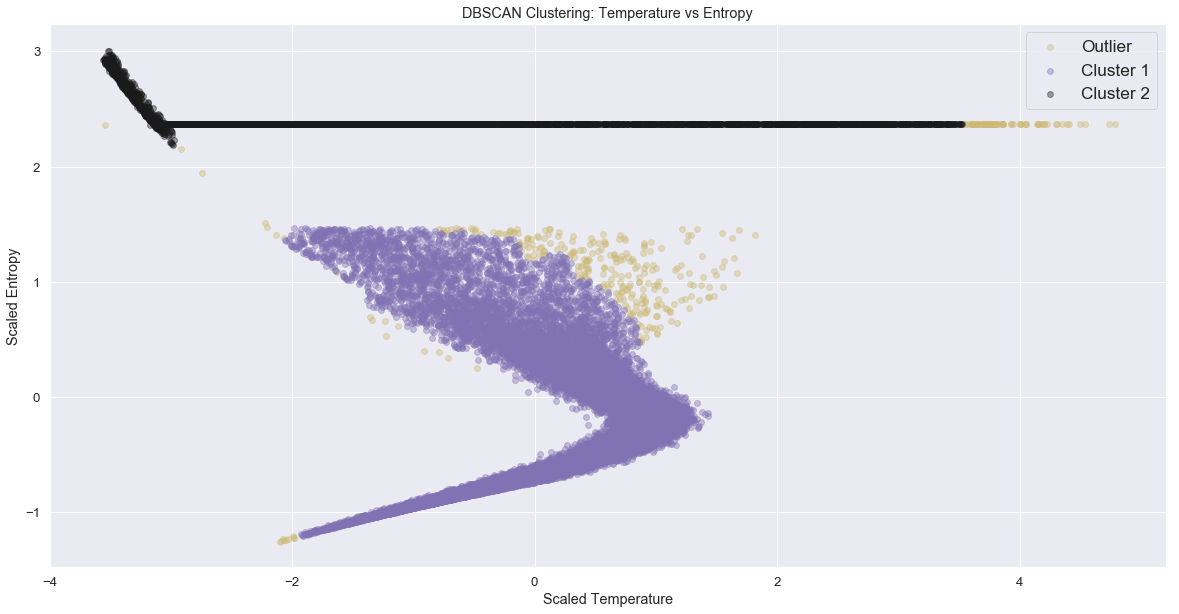

In [10]:
#for DBSCAN clustering

from sklearn.cluster import DBSCAN
plt.subplots(figsize=(20, 10)) #Make figure size reasonable

# Load our data and find the standard score
X = temp_and_ent
X = scaler.fit_transform(X)

# Create our DBSCAN method
dbscan = DBSCAN(eps=0.12, #max distance for which two particles can be considered in the "same neighborhood"
                min_samples=50) #Number of SPH particles needed in neighborhood for datum to be considered "core point"
dbscan.fit_predict(X) # Applying DBSCAN clustering
labels = dbscan.labels_ #Labels of each point to distinguish cluster membership

unique_clusters = np.unique(labels) #find the unique cluster membership labels
colors = ['y','m','k','c','r','g','b'] #will assign a color per cluster. Add many colors in case of many clusters
legend = ['Outlier', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'] #-1 label is outlier, clusters start at 0...

#For each cluster membership label, plot all SPH particles and centriods. Distinguish with different colors
for i, j in enumerate(unique_clusters):
    xi = [X[:,0][k] for k in range(len(X)) if labels[k] == j] 
    yi = [X[:,1][k] for k in range(len(X)) if labels[k] == j]
    plt.scatter(xi, yi, s=35, c=colors[i], alpha=0.4, label=legend[i])

#Plot!
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel("Scaled Temperature")
plt.ylabel("Scaled Entropy")
plt.title('DBSCAN Clustering: Temperature vs Entropy')
plt.show()

In [11]:
# Load our data and find the standard score
labels = dbscan.labels_ #Labels of each point to distinguish cluster membership

unique_clusters = np.unique(labels) #find the unique cluster membership labels
#mydict = {i: X[np.where(dbscan.get_params(X) == i)] for i in range(len(unique_clusters))}

print('\033[1m' "DBSCAN \n" '\033[0m')
print("In original (unscaled) ||| scaled units for [Temperature Entropy]: \n")

cluster_num = ["first", "second", "third", "fourth"] #make sure this corresponds to n_clusters

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(0, len(unique_clusters)-1)): #0 as first element of range to not show outliers
    clus_cluster_scaled = np.array(X[np.where(dbscan.labels_ == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    
    #Find size, bounding box, mean values
    #try:
    print(clus ,"cluster size count:", len(clus_cluster))
    print(clus ,"cluster lower bound:", clus_cluster.min(axis=0), "||| scaled:", clus_cluster_scaled.min(axis=0))
    print(clus ,"cluster mean:", clus_cluster.mean(axis=0), "||| scaled:", clus_cluster_scaled.mean(axis=0))
    print(clus ,"cluster upper bound:", clus_cluster.max(axis=0), "||| scaled:", clus_cluster_scaled.max(axis=0),"\n")
        
    #except ValueError: #raised if '.min()' array is empty.
        #pass

DBSCAN 

In original (unscaled) ||| scaled units for [Temperature Entropy]: 

first cluster size count: 30836
first cluster lower bound: [    5318.126953 42946972.      ] ||| scaled: [-2.05696289 -1.20400848]
first cluster mean: [    8164.28816563 51214030.63977169] ||| scaled: [ 0.10924554 -0.30551794]
first cluster upper bound: [    9903.148438 67499552.      ] ||| scaled: [1.43268912 1.46444494] 

second cluster size count: 3720
second cluster lower bound: [    3349.891357 74170856.      ] ||| scaled: [-3.55498364  2.18950373]
second cluster mean: [    6698.34060025 76205079.38709678] ||| scaled: [-1.00648464  2.41058967]
second cluster upper bound: [   12656.80371 81670136.     ] ||| scaled: [3.52849144 3.00454961] 



<h3> Gaussian Mixture Model (GMM) </h3>

The underlying assumption of GMM is that the clusters can be generated from a superposition of Gaussian distributions. To check if this valid in our simulation, we first plot histograms of the relevant attributes and visually confirm if this is reasonable.

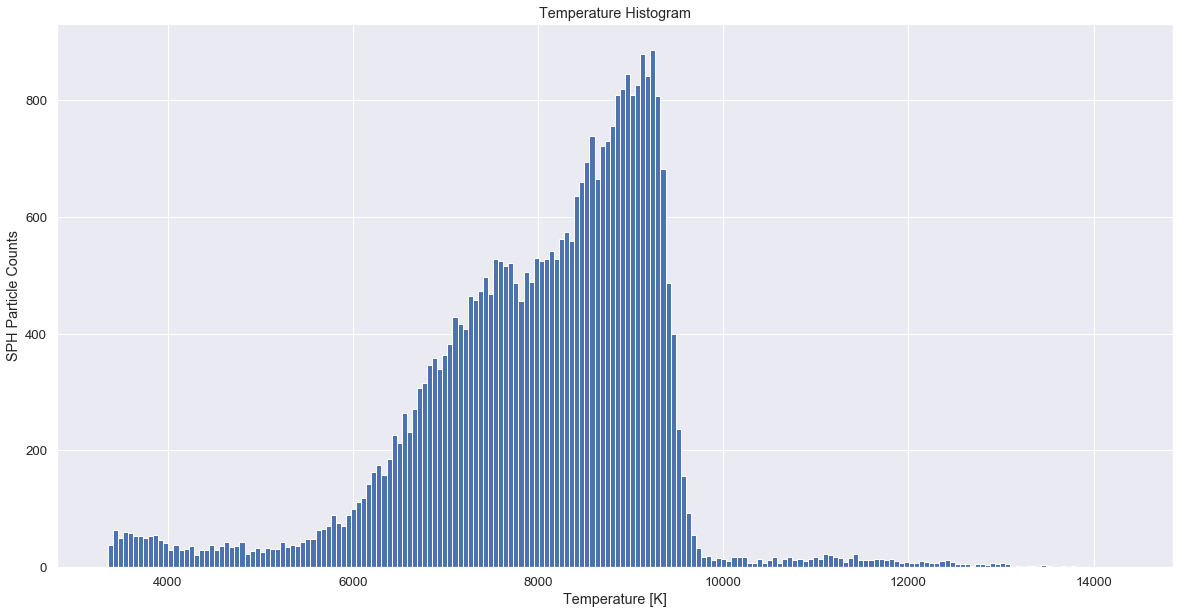

In [12]:
plt.subplots(figsize=(20, 10))
plt.hist(temp_and_ent["temperature"], 200)

#Plot!
plt.xlabel("Temperature [K]")
plt.ylabel("SPH Particle Counts")
plt.title('Temperature Histogram')
plt.show()

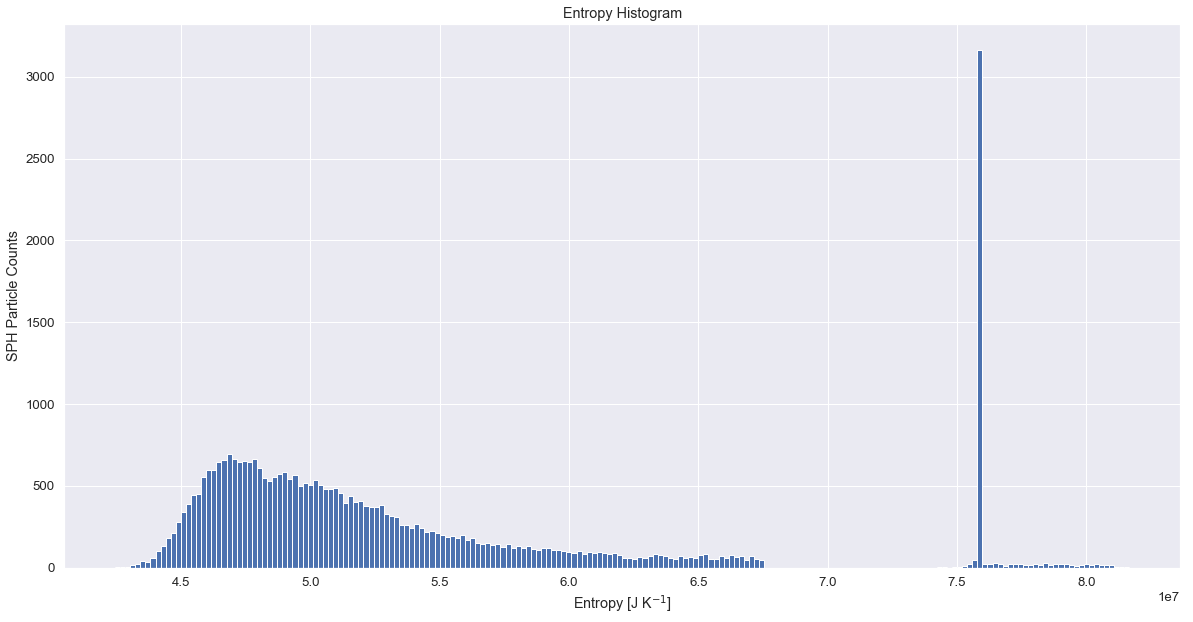

In [13]:
plt.subplots(figsize=(20, 10))
plt.hist(temp_and_ent["entropy"], 200)

#Plot!
plt.xlabel("Entropy [J K$^{-1}$]")
plt.ylabel("SPH Particle Counts")
plt.title('Entropy Histogram')
plt.show()

From this, it looks as though for these two variables, this assumption is ok. It is important to remember that the apparent Dirac delta function at Entropy$\sim$7.6e7 is the limit of a Gaussian:
$$\delta_{a}(x)=\lim_{a\rightarrow0}{\frac {1}{a{\sqrt {2 \pi}}}}\mathrm {e} ^{-x^{2}/2a^{2}}$$

Thus, we cluster by the Gaussian Mixture Model with four components:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


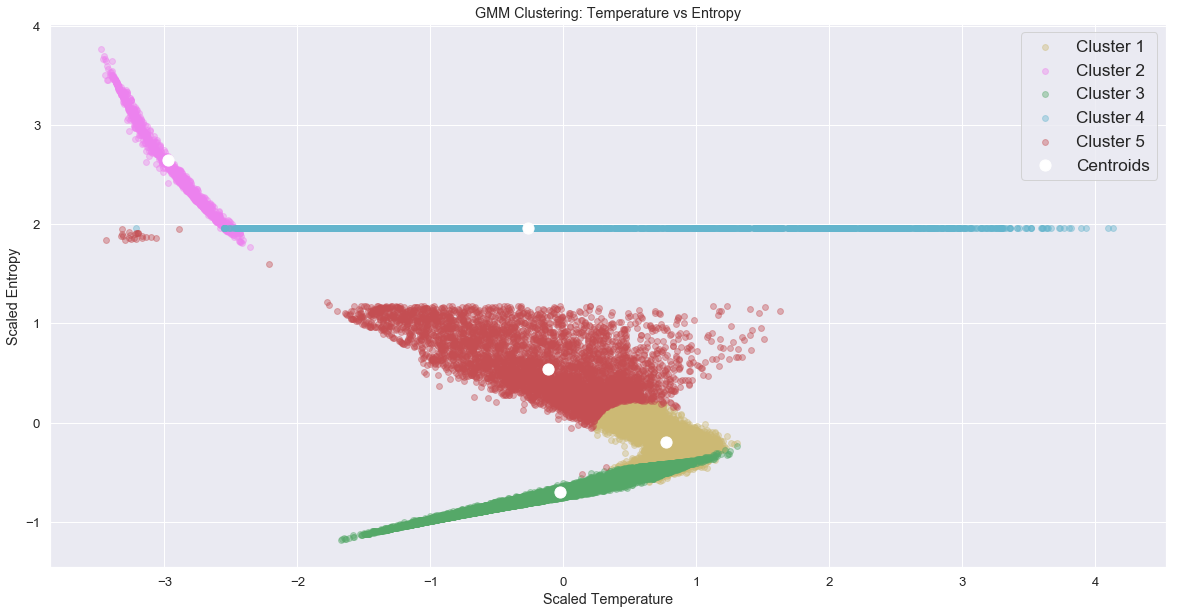

In [6]:
#for GMM clustering

from sklearn.mixture import GaussianMixture
plt.subplots(figsize=(20, 10)) #Make figure size reasonable

# Load our data and find the standard score
X = temp_and_ent
X = scaler.fit_transform(X)

# Create our GMM method
GMM = GaussianMixture(n_components=5, #specify 5 clusters
                      covariance_type='full', #specify covariance matrix for components
                      max_iter=200, #max number of iterations of single run
                      init_params='kmeans', #initialize weights with kmeans
                      random_state=42) #Use a new random number generator seeded by 42
GMM.fit(X) # Applying GMM clustering
GMM_labels = GMM.fit_predict(X) #Labels of each point to distinguish cluster membership

#there's no cluster_centers_ attribute for GMM, so make one
GMM_centers = np.empty(shape=(GMM.n_components, X.shape[1])) 
for i in range(GMM.n_components):
    density = scipy.stats.multivariate_normal(cov=GMM.covariances_[i], mean=GMM.means_[i]).logpdf(X)
    GMM_centers[i, :] = X[np.argmax(density)]

GMM_unique_clusters = np.unique(GMM_labels) #find the unique cluster membership labels
colors = ['y','violet','g','c','r'] #will assign a color per cluster. Add many colors in case it finds many clusters

#For each cluster membership label, plot all SPH particles and centriods. Distinguish with different colors
for i, j in enumerate(GMM_unique_clusters):
    xi = [X[:,0][k] for k in range(len(X)) if GMM_labels[k] == j] 
    yi = [X[:,1][k] for k in range(len(X)) if GMM_labels[k] == j]
    plt.scatter(xi, yi, s=35, c=colors[i], alpha=0.4, label='Cluster '+ str(j+1))
plt.scatter(GMM_centers[:,0], GMM_centers[:,1], s=125, marker='o', c=['white'], alpha=1.0, label='Centroids')

#Plot!
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel("Scaled Temperature")
plt.ylabel("Scaled Entropy")
plt.title('GMM Clustering: Temperature vs Entropy')
plt.show()

In [ ]:
print('\033[1m' "Gaussian Mixture Model \n" '\033[0m')
print("In original (unscaled) ||| scaled units for [Temperature Entropy]: \n")

cluster_num = ["first", "second", "third", "fourth"] #make sure this corresponds to n_clusters

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(len(GMM_unique_clusters)) ):
    clus_cluster_scaled = np.array(X[np.where(GMM_labels == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    
    #Find size, bounding box, mean values
    try:
        print(clus ,"cluster size count:", len(clus_cluster))
        print(clus ,"cluster lower bound:", clus_cluster.min(axis=0), "||| scaled:", clus_cluster_scaled.min(axis=0))
        print(clus ,"cluster mean:", clus_cluster.mean(axis=0), "||| scaled:", clus_cluster_scaled.mean(axis=0))
        print(clus ,"cluster upper bound:", clus_cluster.max(axis=0), "||| scaled:", clus_cluster_scaled.max(axis=0))
        
        #Centriod stats for each cluster
        clus_centriod_scaled = GMM_centers[i]
        clus_centriod = scaler.inverse_transform(GMM_centers[i])
        print(clus ,"cluster centriod loc:", clus_centriod, "||| scaled:", clus_centriod_scaled,"\n")
        
    except ValueError: #raised if '.min()' array is empty.
        pass

> ## 3.x. (Optional) Visualizing clusters by color

> How do we know the clustering algorithms are representing physical structures within the data and not mathematical artifacts? One way to visually inspect the validity of the algorithm is to visualize the entire dataset in Houdini, and color each particle by its membership to a particular cluster, as shown above. For example, visualize the dataset such that gold particles are members of cluster 1, magenta particles are members of cluster 2, etc. 

> To do so, we need to find the cluster membership ID label of each particle into a .txt file and import this in Houdini. Note that these steps are done **after** following the steps in the "From Results to Render" .ipynb notebook, as instead of using the shader network to create a realistic, cinematic visualizaiton, we will extend that setup to map cluster to cluster ID. 

In [93]:
f = open("clustering_shader/map_cluster_to_id.txt", "w+") # create a new .txt file to write out cluster membership id

map_id_to_cluster = np.array(GMM.predict(X)+1) # add 1 such that cluster membership matches legend in plot above
print(map_id_to_cluster)

for j in map_id_to_cluster:
    f.write("%g \n" % j)
f.close()

[5 3 5 3 1 3 5 1 4 5 3 1 4 3 3 3 3 1 5 3 3 3 1 5 3 3 3 5 1 1 3 3 1 1 5 3 4
 3 3 3 3 1 3 4 1 3 5 3 1 4 4 1 1 5 3 3 3 1 3 3 3 3 1 3 3 3 3 5 3 1 4 3 3 3
 3 1 5 3 1 3 3 1 3 1 3 3 3 4 1 1 1 3 3 3 3 3 1 1 3 3 3 1 3 3 5 3 3 3 1 1 1
 3 3 5 4 3 3 5 3 4 3 4 5 3 3 3 3 3 3 4 3 5 4 3 3 4 3 3 3 3 5 1 1 3 3 3 1 1
 3 4 3 5 3 1 3 5 3 4 2 3 3 3 3 3 1 3 1 1 3 1 3 3 1 1 4 4 3 5 2 4 3 3 3 3 3
 4 3 3 1 3 3 3 1 3 1 1 5 1 3 2 3 3 2 5 5 1 5 3 1 3 3 3 1 3 1 5 2 3 3 3 3 3
 3 3 3 1 3 1 5 3 3 3 1 1 1 5 3 3 3 3 1 1 3 1 5 3 3 3 3 3 4 3 3 3 3 3 3 5 3
 3 5 3 3 3 1 3 3 1 3 5 3 3 3 3 1 3 1 1 1 1 3 1 3 5 5 2 3 3 3 5 3 1 3 3 5 3
 1 1 3 5 3 3 3 1 1 4 3 3 3 3 5 4 5 3 3 1 1 3 1 1 3 5 3 3 4 1 3 1 1 3 3 3 1
 3 3 3 4 5 1 1 5 3 5 3 3 5 1 3 3 3 3 3 3 4 5 1 5 3 1 3 3 5 3 5 3 1 5 3 3 2
 4 3 5 1 3 3 2 1 4 3 3 1 1 4 3 3 1 1 2 3 3 4 3 5 3 3 5 3 1 3 1 1 4 1 3 3 3
 3 4 1 3 5 3 3 3 2 3 5 5 1 3 1 2 1 3 3 3 3 3 1 3 1 3 1 3 3 3 3 3 3 1 3 3 3
 5 2 2 3 3 1 4 5 2 5 3 1 2 3 2 1 1 1 3 1 1 1 3 5 1 2 3 3 3 5 3 3 3 4 3 3 3
 5 3 3 3 5 5 1 4 3 1 3 4 

> Next, in the Houdini scene file, navigate inside the /obj/synestia Geometry node and do the following:
+ We preprocessed this particular dataset by thresholding smoothLen > 90 and density > 3.4. Thus, create two delete nodes. Set Entity to "Points", and change Operation to "Filter by Expression". In Filter Expression, write "@smoothLen > 90" in the first node and "@density > 3.4" for the second node. Connect the output of the syenstia.bgeo file node to the input of the first delete node, and connect the output of the first delete node to the input of the second delete node. This is important such that the exact order of the particles in the scene file matches the particles clustered by the algorithms, such that the IDs match to the correct particles in Houdini. 
+ Create an "Attribute Create" node named 'pscale_from_smoothLen'. Make the Name parameter "pscale" and change the Value to "@smoothLen * 1". Connect the output of the second delete node to the input of pscale_from_smoothLen.
+ Not attached to any node, create a "Table Import" node and change the name to "import_cluster_id" In the File parameter, click the file/arrow icon and find the map_cluster_to_id.txt file. Set the Number of Attributes to "1", and make the Name "map_id_to_clus".
+ Create a second "Attribute Create" node. This is the node where we'll make a new attribute (to be seen in the Geometry Spreadsheet) called "map_id_to_clus". Make the Name parameter "map_id_to_clus". Change the Size to "1" and change the Value to "point("../import_cluster_id", PT, "map_id_to_clus", 0)" in the first column. Make sure the Class is "Point" because this is point data. Connect the output of 'pscale_from_smoothLen' to the input of 'map_id_to_clus'.
+ Create an "Attribute VOP" node. Connect the output of 'map_id_to_clus' to the input of this node. This is the node that will allow us to see the particle with its matching cluster color to the GMM results in the Scene View (but not yet in the Render View). To do this, dive inside this "Attribute VOP" node and make this simple network:
> > Make an "Import Point Attribute" node. Change the Signature to "Float" and Input to "First Input". Fill in the Attribute parameter to "map_id_to_clus". This will use our cluster ID results we read in from the .txt file. 
> > Create a "Fit Range" node. Connect **result** of the "Import Point Attribute" node to **val** of this "Fit Range" node. Middle click on srcmin and select "Promote Paramter". Do the same for srcmax. Ensure that the Ramp Type is "RGB Color Ramp". Connect **ramp** output to **Cd** input of "geometryvopoutput1". 
+ Jump back up to /obj/synestia. Highlight the "Attribute VOP" node and go to the ramp. Create 4 new point markers and set the Interpolation to "Constant" for all points. Set the first point to "0", the second point to "0.2", the third point to "0.4" the fourth point to "0.6", the fifth point to "0.8", and the last point to "1". The division between the points are the individual clusters. Thus, we need to color these clusters by their color in the GMM clustering result plot. Set the first point marker (hence, cluster 1) to gold (R,G,B) = (0.9, 0.584, 0); the second point to magenta (0.9, 0, 0.911), the third to green (0, 0.9, 0), the fourth point to cyan (0, 0.45, 0.9) and the last two positions (the final point) to red (0.9, 0, 0). Finally, set the Minimum Value in Source Range to "1" and Maximum Value in Source Range to "5". Now the points with cluster 1 in the GMM will be colored gold, with cluster 2 will be magenta, etc. To see how this looks in the Scene View, select the Display/Render flag on this "Attribute Vop" node. It should look like this:

![](synestia_clustering_plots/Scene_View_GMM_5_clus.png)

> Zooming in and looking closely, we can also identify some outliers:

![](synestia_clustering_plots/GMM_5_cluster_outlier.png)

> Looking back to our GMM clustering results below, we can see that some of these blue (cluster 4) and red (cluster 5) classifications should probably be magenta (cluster 2) classifications. It is possible that these are outliers. Though, in the final render these outliers don't make a noticeable visible impact.

![](synestia_clustering_plots/GMM_5_cluster.png)

> This is one thing, but how does the render look? To do this, we need it to match our setup we achieved in the "From_Results_to_Render" notebook. 
+ After the "Attribute VOP" node, create a "Material" node, and have it match identically to that of the "varsToShader" material node we created in the other notebook. This is because we'll be using the same shader network with one additional change, so we need all the other attributes read-in correctly for the shader to do its job. In fact, you can simply copy the varsToShader node directly and paste it in your new network. Connect the "Attribute VOP node" to this.
+ Finally, create a "Null" node. Make sure the box for "Copy Input" is selected. And connect it to the "varsToShader" node. Renaming it something like "OUT_EMISSIVE_SPRITES" is helpful. Enable the blue display flag.
+ Now that out geometry is setup, we need to slightly add to our "simple_synestia_shader" from before. So jump over to /shop/simple_synestia_shader and we'll add the following into its network structure:
+ Below the yellow network box labeled "Temperature and Density", create another network box and name it "Map ID to Cluster". In this network box, create a parameter ramp for "map_id_to_clus" (or whatever you named the attribute for this; it should match what it is the geometry spreadsheet). Create a Fit Ramp node as usual, and promote srcmin and srcmax. Then create an RBG ramp and connect these together. 
+ Finally, connect the **output** of the ramp parameter node to the __first__ **input** of emitMultiply. This will break the connection of temperatureColoRamp, which is what we want. We want to color by these artificial cluster colors and not realistically with an emissive color ramp.
+ Our network setup should look something like this:

> And our render for visualizing cluster by color, looking head-on, is:

![](synestia_clustering_plots/GMM_5_cluster_color.jpg)

> Note that this is not a vertical slice through the data (though a vertical slice visualization would look very similar), but looking edge on where the midplane cuts through the center of the image. We can see 5 distinct clusters, but yellow, green, and some red get mixed together in the core. This could make for an argument for yellow + green really belonging to the same cluster, and that these two don't have strong eough physically meaningful difference to be considered different structures to justify labelling them as two distinct clusters. 

> Here is the GMM temperature mapping for the same image (rendered to 1%):

![](synestia_clustering_plots/org_GMM_id_to_clus_ref.jpg)

> And here are those two images overlayed, where the 5 cluster coloring render is the top layer at 75% transparency. This way we can see that the distinct clusters do in fact appear to represent the different structures in the final render.

![](synestia_clustering_plots/overlayed_renders.jpg)

<h3> Variational Bayesian Gaussian Mixture Model (VBGMM) </h3>

Now cluster by the Variational Bayesian Gaussian Mixture Model (VBGMM) with four components:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


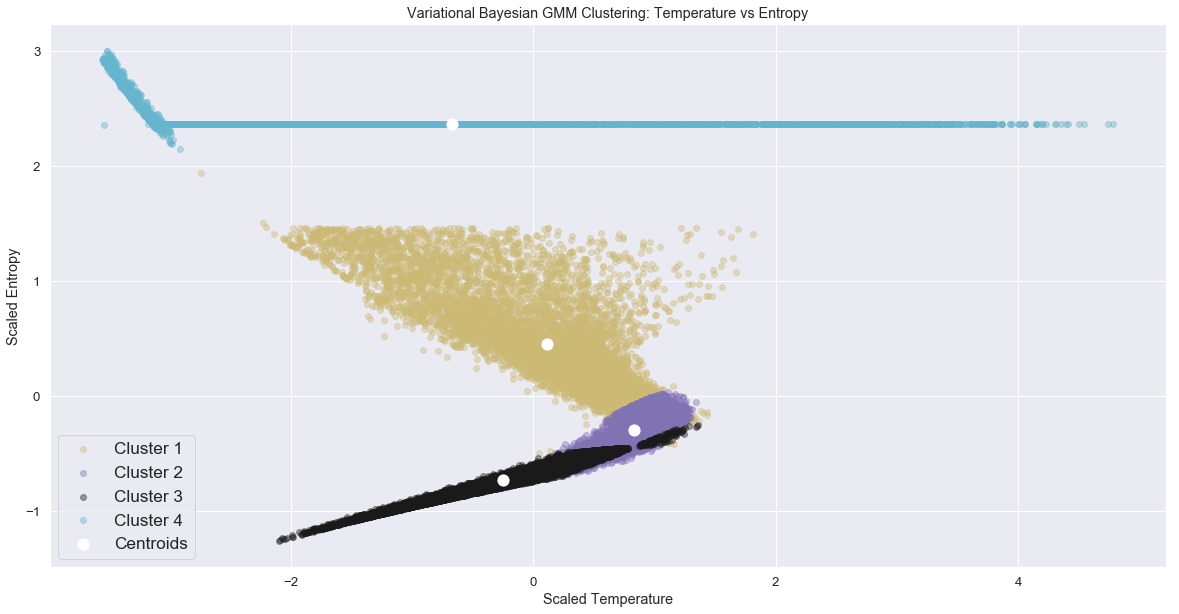

In [16]:
#for VBGMM clustering

from sklearn.mixture import BayesianGaussianMixture
plt.subplots(figsize=(20, 10)) #Make figure size reasonable

# Load our data and find the standard score
X = temp_and_ent
X = scaler.fit_transform(X)

# Create our Variational Bayesian GMM (VBGMM) method
VBGMM = BayesianGaussianMixture(n_components=4, #specify 4 clusters
                                covariance_type='full', #specify covariance matrix for components
                                max_iter=400, #set high number of iterations to ensure convergence
                                init_params='kmeans', #initialize weights with kmeans
                                random_state=42) #Use a new random number generator seeded by 42
VBGMM.fit(X) # Applying VBGMM clustering
VBGMM_labels = VBGMM.fit_predict(X) #Labels of each point to distinguish cluster membership

#there's no cluster_centers_ attribute for GMM, so make one
VBGMM_centers = np.empty(shape=(VBGMM.n_components, X.shape[1])) 
for i in range(VBGMM.n_components):
    density = scipy.stats.multivariate_normal(cov=VBGMM.covariances_[i], mean=VBGMM.means_[i]).logpdf(X)
    VBGMM_centers[i, :] = X[np.argmax(density)]

VBGMM_unique_clusters = np.unique(VBGMM_labels) #find the unique cluster membership labels
colors = ['y','m','k','c'] #will assign a color per cluster. Add many colors in case it finds many clusters

#For each cluster membership label, plot all SPH particles and centriods. Distinguish with different colors
for i, j in enumerate(VBGMM_unique_clusters):
    xi = [X[:,0][k] for k in range(len(X)) if VBGMM_labels[k] == j] 
    yi = [X[:,1][k] for k in range(len(X)) if VBGMM_labels[k] == j]
    plt.scatter(xi, yi, s=35, c=colors[i], alpha=0.4, label='Cluster '+ str(j+1))
plt.scatter(VBGMM_centers[:,0], VBGMM_centers[:,1], s=125, marker='o', c=['white'], alpha=1.0, label='Centroids')

#Plot!
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel("Scaled Temperature")
plt.ylabel("Scaled Entropy")
plt.title('Variational Bayesian GMM Clustering: Temperature vs Entropy')
plt.show()

In [17]:
print('\033[1m' "Variational Bayesian Gaussian Mixture Model \n" '\033[0m')
print("In original (unscaled) ||| scaled units for [Temperature Entropy]: \n")

cluster_num = ["first", "second", "third", "fourth"] #make sure this corresponds to n_clusters

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(len(VBGMM_unique_clusters)) ):
    clus_cluster_scaled = np.array(X[np.where(VBGMM_labels == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    
    #Find size, bounding box, mean values
    try:
        print(clus ,"cluster size count:", len(clus_cluster))
        print(clus ,"cluster lower bound:", clus_cluster.min(axis=0), "||| scaled:", clus_cluster_scaled.min(axis=0))
        print(clus ,"cluster mean:", clus_cluster.mean(axis=0), "||| scaled:", clus_cluster_scaled.mean(axis=0))
        print(clus ,"cluster upper bound:", clus_cluster.max(axis=0), "||| scaled:", clus_cluster_scaled.max(axis=0))
        
        #Centriod stats for each cluster
        clus_centriod_scaled = VBGMM_centers[i]
        clus_centriod = scaler.inverse_transform(VBGMM_centers[i])
        print(clus ,"cluster centriod loc:", clus_centriod, "||| scaled:", clus_centriod_scaled,"\n")
        
    except ValueError: #raised if '.min()' array is empty.
        pass

Variational Bayesian Gaussian Mixture Model 

In original (unscaled) ||| scaled units for [Temperature Entropy]: 

first cluster size count: 8285
first cluster lower bound: [    4417.585938 49465016.      ] ||| scaled: [-2.74236312 -0.49560648]
first cluster mean: [    8105.75023936 58571429.83126131] ||| scaled: [0.06469243 0.49410789]
first cluster upper bound: [   10406.61523 71904696.     ] ||| scaled: [1.81587684 1.94321017]
first cluster centriod loc: [    8173.42627 58188512.     ] ||| scaled: [0.11620054 0.45249114] 

second cluster size count: 7968
second cluster lower bound: [    8251.933594 47779608.      ] ||| scaled: [ 0.17595233 -0.67878204]
second cluster mean: [    9148.02260191 51417415.08232932] ||| scaled: [ 0.85796414 -0.28341346]
second cluster upper bound: [    9782.396484 54388636.      ] ||| scaled: [1.34078502 0.03950839]
second cluster centriod loc: [    9117.982422 51332760.      ] ||| scaled: [ 0.83510061 -0.29261405] 

third cluster size count: 14864
third 

<h2> 4. Clustering results informing Houdini shader networks </h2>

Now with the necessary clustering results, we will test each of the different algorithms in shading the synestia simulation using a pre-made emissive color scheme, often used by the AVL at NCSA. This color scheme maps any temperature value [0, ~140000 K] to its associated (R,G,B, $\alpha$) color value using an emissive blackbody color temperature scale, like one shown in https://en.wikipedia.org/wiki/Color_temperature.

Thus, we import the color scheme:

In [18]:
blackbody = pd.read_csv('blackbody.csv')
print(blackbody)

             R         G    B  alpha
0     0.010000  0.000000  0.0      1
1     0.010000  0.000000  0.0      1
2     0.010000  0.000000  0.0      1
3     0.010000  0.000000  0.0      1
4     0.010000  0.000000  0.0      1
5     0.010000  0.000000  0.0      1
6     0.010000  0.000000  0.0      1
7     0.010000  0.000000  0.0      1
8     0.010000  0.000000  0.0      1
9     0.010000  0.000000  0.0      1
10    0.010000  0.000000  0.0      1
11    0.010000  0.000000  0.0      1
12    0.010000  0.000000  0.0      1
13    0.010000  0.000000  0.0      1
14    0.010000  0.000000  0.0      1
15    0.010000  0.000000  0.0      1
16    0.010000  0.000000  0.0      1
17    0.010000  0.000000  0.0      1
18    0.010000  0.000000  0.0      1
19    0.010000  0.000000  0.0      1
20    0.010000  0.000000  0.0      1
21    0.010000  0.000000  0.0      1
22    0.010000  0.000000  0.0      1
23    0.010000  0.000000  0.0      1
24    0.010000  0.000000  0.0      1
25    0.010000  0.000000  0.0      1
2

In Houdini, each *Point No.* and *Position* value in the Temperature Color Ramp of the Material Shader Builder will be mapped to the lower bouding box, centroid, and upper bounding box values of each cluster. Each color will be the mapped (R,G,B) value from the associated temperature at those specific locations of interest. Set the *Interpolation* to B-Spline at each point position.

<h3> K-means </h3>

In [27]:
print('\033[1m' "K-means \n" '\033[0m')
print("Suggested Color Map positions & (R,G,B) colors \n")

cluster_num = ["first", "second", "third", "fourth"] #make sure this corresponds to n_clusters

### Write out (Pos, (R, G, B)) values from above to new color ramp file called "kmeans_clustering_colors"
f = open("clustering_shader/kmeans_clustering_colors.txt", "w+")

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(kmeans.n_clusters) ):
    clus_cluster_scaled = np.array(X[np.where(kmeans.labels_ == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    print(clus ,"cluster size count:", len(clus_cluster))
    
    #Centriod stats for each cluster
    clus_centriod_scaled = kmeans.cluster_centers_[i]
    clus_centriod = scaler.inverse_transform(kmeans.cluster_centers_[i])
    
    #Suggested color map positions
    bb_min_row_entry = int(clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    bb_centriod_row_entry = int(clus_centriod[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    bb_max_row_entry = int(clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    
    print(clus ,"cluster lower bound pos:", clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_min_row_entry], 
          blackbody['G'][bb_min_row_entry], 
          blackbody['B'][bb_min_row_entry]))
    print(clus ,"cluster centriod loc pos:", clus_centriod[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_centriod_row_entry], 
          blackbody['G'][bb_centriod_row_entry], 
          blackbody['B'][bb_centriod_row_entry]))
    print(clus ,"cluster upper bound pos:", clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_max_row_entry], 
          blackbody['G'][bb_max_row_entry], 
          blackbody['B'][bb_max_row_entry]), "\n")
    
    print("---------------------------------------------")
    
    #Suggested color map positions
    f.write("%g %g %g %g \n" % (0, 0.01, 0, 0)) #this is dark brown at lowest end
    
    f.write("%g %g %g %g \n" % (clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_min_row_entry],
                                    blackbody['G'][bb_min_row_entry],
                                    blackbody['B'][bb_min_row_entry]))
    f.write("%g %g %g %g \n" % (clus_centriod[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_centriod_row_entry],
                                    blackbody['G'][bb_centriod_row_entry],
                                    blackbody['B'][bb_centriod_row_entry]))
    f.write("%g %g %g %g \n" % (clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_max_row_entry],
                                    blackbody['G'][bb_max_row_entry],
                                    blackbody['B'][bb_max_row_entry]))
f.close()

K-means 

Suggested Color Map positions & (R,G,B) colors 

first cluster size count: 18905
first cluster lower bound pos: 0.49516527661335197 (0.48064300000000004, 0.261667, 0.01456)
first cluster centriod loc pos: 0.6127677793578921 (0.6650659999999999, 0.543558, 0.172957)
first cluster upper bound pos: 0.6962297921258105 (0.78738, 0.73352, 0.33865100000000004) 

---------------------------------------------
second cluster size count: 4246
second cluster lower bound pos: 0.23411865567059117 (0.129189, 0.012228, 0.0)
second cluster centriod loc pos: 0.4065566548710423 (0.327275, 0.101684, 0.0)
second cluster upper bound pos: 0.5706665896412275 (0.600884, 0.449708, 0.099941) 

---------------------------------------------
third cluster size count: 10696
third cluster lower bound pos: 0.36767021179024795 (0.258973, 0.061813, 0.0)
third cluster centriod loc pos: 0.5117955289490118 (0.513984, 0.3092, 0.028495999999999997)
third cluster upper bound pos: 0.5755443449431417 (0.605623999999999

<h3> Mini-batch K-means </h3>

In [28]:
print('\033[1m' "Mini-batch K-means \n" '\033[0m')
print("Suggested Color Map positions & (R,G,B) colors \n")

cluster_num = ["first", "second", "third", "fourth"] #make sure this corresponds to n_clusters

### Write out (Pos, (R, G, B)) values from above to new color ramp file called "minibatchkmeans_clustering_colors"
f = open("clustering_shader/minibatchkmeans_clustering_colors.txt", "w+")

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(minibatchkmeans.n_clusters) ):
    clus_cluster_scaled = np.array(X[np.where(minibatchkmeans.labels_ == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    print(clus ,"cluster size count:", len(clus_cluster))
    
    #Centriod stats for each cluster
    clus_centriod_scaled = minibatchkmeans.cluster_centers_[i]
    clus_centriod = scaler.inverse_transform(minibatchkmeans.cluster_centers_[i])
    
    #Suggested color map positions
    bb_min_row_entry = int(clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    bb_centriod_row_entry = int(clus_centriod[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    bb_max_row_entry = int(clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    
    print(clus ,"cluster lower bound pos:", clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_min_row_entry], 
          blackbody['G'][bb_min_row_entry], 
          blackbody['B'][bb_min_row_entry]))
    print(clus ,"cluster centriod loc pos:", clus_centriod[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_centriod_row_entry], 
          blackbody['G'][bb_centriod_row_entry], 
          blackbody['B'][bb_centriod_row_entry]))
    print(clus ,"cluster upper bound pos:", clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_max_row_entry], 
          blackbody['G'][bb_max_row_entry], 
          blackbody['B'][bb_max_row_entry]), "\n")
    
    print("---------------------------------------------")
    
    #Suggested color map positions
    f.write("%g %g %g %g \n" % (0, 0.01, 0, 0)) #this is dark brown at lowest end
    
    f.write("%g %g %g %g \n" % (clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_min_row_entry],
                                    blackbody['G'][bb_min_row_entry],
                                    blackbody['B'][bb_min_row_entry]))
    f.write("%g %g %g %g \n" % (clus_centriod[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_centriod_row_entry],
                                    blackbody['G'][bb_centriod_row_entry],
                                    blackbody['B'][bb_centriod_row_entry]))
    f.write("%g %g %g %g \n" % (clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_max_row_entry],
                                    blackbody['G'][bb_max_row_entry],
                                    blackbody['B'][bb_max_row_entry]))
f.close()

Mini-batch K-means 

Suggested Color Map positions & (R,G,B) colors 

first cluster size count: 18250
first cluster lower bound pos: 0.5021235095592032 (0.49931400000000004, 0.281943, 0.019121)
first cluster centriod loc pos: 0.6149327854686695 (0.669067, 0.547347, 0.176101)
first cluster upper bound pos: 0.703392469004094 (0.797668, 0.75541, 0.36070399999999997) 

---------------------------------------------
second cluster size count: 4574
second cluster lower bound pos: 0.23411865567059117 (0.129189, 0.012228, 0.0)
second cluster centriod loc pos: 0.4286401434846528 (0.362875, 0.138878, 0.0)
second cluster upper bound pos: 0.5927413356230014 (0.630487, 0.491277, 0.13716199999999998) 

---------------------------------------------
third cluster size count: 11101
third cluster lower bound pos: 0.36767021179024795 (0.258973, 0.061813, 0.0)
third cluster centriod loc pos: 0.5182511243156045 (0.521986, 0.31590100000000004, 0.033415)
third cluster upper bound pos: 0.5815684684605521 (0.61

<h3> DBSCAN </h3>

In [29]:
print('\033[1m' "DBSCAN \n" '\033[0m')
print("Suggested Color Map positions & (R,G,B) colors \n")

cluster_num = ["first", "second"] #make sure this corresponds to n_clusters

### Write out (Pos, (R, G, B)) values from above to new color ramp file called "dbscan_clustering_colors"
f = open("clustering_shader/dbscan_clustering_colors.txt", "w+")

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(len(np.unique(dbscan.labels_))) ):
    clus_cluster_scaled = np.array(X[np.where(dbscan.labels_ == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    print(clus ,"cluster size count:", len(clus_cluster))
    
    #Suggested color map positions
    try:
        bb_min_row_entry = int(clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
        bb_max_row_entry = int(clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    
        print(clus ,"cluster lower bound pos:", clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_min_row_entry], 
          blackbody['G'][bb_min_row_entry], 
          blackbody['B'][bb_min_row_entry]))
        print(clus ,"cluster upper bound pos:", clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_max_row_entry], 
          blackbody['G'][bb_max_row_entry], 
          blackbody['B'][bb_max_row_entry]), "\n")
    
        print("---------------------------------------------")
        
        #Suggested color map positions
        f.write("%g %g %g %g \n" % (0, 0.01, 0, 0)) #this is dark brown at lowest end
    
        f.write("%g %g %g %g \n" % (clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_min_row_entry],
                                    blackbody['G'][bb_min_row_entry],
                                    blackbody['B'][bb_min_row_entry]))
        f.write("%g %g %g %g \n" % (clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_max_row_entry],
                                    blackbody['G'][bb_max_row_entry],
                                    blackbody['B'][bb_max_row_entry]))
    
    except ValueError: #raised if '.min()' array is empty.
        pass
    
f.close()

DBSCAN 

Suggested Color Map positions & (R,G,B) colors 

first cluster size count: 30836
first cluster lower bound pos: 0.3716755560803991 (0.264689, 0.063177, 0.0)
first cluster upper bound pos: 0.6921155202141307 (0.7839510000000001, 0.723816, 0.329335) 

---------------------------------------------
second cluster size count: 3720
second cluster lower bound pos: 0.23411865567059117 (0.129189, 0.012228, 0.0)
second cluster upper bound pos: 0.8845641705602787 (0.9914270000000001, 0.9914270000000001, 0.9735940000000001) 

---------------------------------------------
third cluster size count: 0


<h3> Gaussian Mixture Model </h3>

In [30]:
print('\033[1m' "Gaussian Mixture Model \n" '\033[0m')
print("In original (unscaled) ||| scaled units for [Temperature Entropy]: \n")

cluster_num = ["first", "second", "third", "fourth", "fifth"] #make sure this corresponds to n_clusters

### Write out (Pos, (R, G, B)) values from above to new color ramp file called "gmm_clustering_colors"
f = open("clustering_shader/gmm_clustering_colors.txt", "w+")

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(len(GMM_unique_clusters)) ):
    clus_cluster_scaled = np.array(X[np.where(GMM_labels == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    print(clus ,"cluster size count:", len(clus_cluster))
    
    #Centriod stats for each cluster
    clus_centriod_scaled = GMM_centers[i]
    clus_centriod = scaler.inverse_transform(GMM_centers[i])
        
    #Suggested color map positions
    try:
        bb_min_row_entry = int(clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
        bb_centriod_row_entry = int(clus_centriod[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
        bb_max_row_entry = int(clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    
        print(clus ,"cluster lower bound pos:", clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_min_row_entry], 
          blackbody['G'][bb_min_row_entry], 
          blackbody['B'][bb_min_row_entry]))
        print(clus ,"cluster centriod loc pos:", clus_centriod[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_centriod_row_entry], 
          blackbody['G'][bb_centriod_row_entry], 
          blackbody['B'][bb_centriod_row_entry]))
        print(clus ,"cluster upper bound pos:", clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
         (blackbody['R'][bb_max_row_entry], 
          blackbody['G'][bb_max_row_entry], 
          blackbody['B'][bb_max_row_entry]), "\n")
    
        print("---------------------------------------------")
        
        #Suggested color map positions
        f.write("%g %g %g %g \n" % (0, 0.01, 0, 0)) #this is dark brown at lowest end
    
        f.write("%g %g %g %g \n" % (clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_min_row_entry],
                                    blackbody['G'][bb_min_row_entry],
                                    blackbody['B'][bb_min_row_entry]))
        f.write("%g %g %g %g \n" % (clus_centriod[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_centriod_row_entry],
                                    blackbody['G'][bb_centriod_row_entry],
                                    blackbody['B'][bb_centriod_row_entry]))
        f.write("%g %g %g %g \n" % (clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_max_row_entry],
                                    blackbody['G'][bb_max_row_entry],
                                    blackbody['B'][bb_max_row_entry]))
    
    except ValueError: #raised if '.min()' array is empty.
        pass
    
f.close()

Gaussian Mixture Model 

In original (unscaled) ||| scaled units for [Temperature Entropy]: 

first cluster size count: 3974
first cluster lower bound pos: 0.3087381562248879 (0.195102, 0.032517000000000004, 0.0)
first cluster centriod loc pos: 0.522880681143397 (0.5301779999999999, 0.325818, 0.036666000000000004)
first cluster upper bound pos: 0.7273020250754061 (0.8233879999999999, 0.782751, 0.42839399999999994) 

---------------------------------------------
second cluster size count: 9442
second cluster lower bound pos: 0.5551310189950867 (0.583333, 0.409602, 0.071616)
second cluster centriod loc pos: 0.6275661135432646 (0.6902149999999999, 0.586888, 0.202674)
second cluster upper bound pos: 0.6918654506669286 (0.7839510000000001, 0.723816, 0.329335) 

---------------------------------------------
third cluster size count: 17701
third cluster lower bound pos: 0.36767021179024795 (0.258973, 0.061813, 0.0)
third cluster centriod loc pos: 0.5515961249137002 (0.5776180000000001, 0.3982

In [31]:
print('\033[1m' "Variational Bayesian Gaussian Mixture Model \n" '\033[0m')
print("Position value in shader ||| (R, G, B): \n")

cluster_num = ["first", "second", "third", "fourth"] #make sure this corresponds to n_clusters

### Write out (Pos, (R, G, B)) values from above to new color ramp file called "vbgmm_clustering_colors"
f = open("clustering_shader/vbgmm_clustering_colors.txt", "w+")

#find useful stats for each cluster
for clus, i in zip( cluster_num, range(len(VBGMM_unique_clusters)) ):
    clus_cluster_scaled = np.array(X[np.where(VBGMM_labels == i)]) #original scaled data
    clus_cluster = scaler.inverse_transform(clus_cluster_scaled) #return to useful numbers for visualization
    print(clus ,"cluster size count:", len(clus_cluster))
    
    #Centriod stats for each cluster
    clus_centriod_scaled = VBGMM_centers[i]
    clus_centriod = scaler.inverse_transform(VBGMM_centers[i])
        
    #Suggested color map positions
    try:
        bb_min_row_entry = int(clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
        bb_centriod_row_entry = int(clus_centriod[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
        bb_max_row_entry = int(clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature'])*len(blackbody))-1
    
        print(clus ,"cluster lower bound pos:", clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']), "|||",
         (blackbody['R'][bb_min_row_entry], 
          blackbody['G'][bb_min_row_entry], 
          blackbody['B'][bb_min_row_entry]))
        print(clus ,"cluster centriod loc pos:", clus_centriod[0]/max(temp_and_ent['temperature']), "|||",
         (blackbody['R'][bb_centriod_row_entry], 
          blackbody['G'][bb_centriod_row_entry], 
          blackbody['B'][bb_centriod_row_entry]))
        print(clus ,"cluster upper bound pos:", clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']), "|||",
         (blackbody['R'][bb_max_row_entry], 
          blackbody['G'][bb_max_row_entry], 
          blackbody['B'][bb_max_row_entry]), "\n")
    
        print("---------------------------------------------")
        
        #Suggested color map positions
        f.write("%g %g %g %g \n" % (0, 0.01, 0, 0)) #this is dark brown at lowest end
    
        f.write("%g %g %g %g \n" % (clus_cluster.min(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_min_row_entry],
                                    blackbody['G'][bb_min_row_entry],
                                    blackbody['B'][bb_min_row_entry]))
        f.write("%g %g %g %g \n" % (clus_centriod[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_centriod_row_entry],
                                    blackbody['G'][bb_centriod_row_entry],
                                    blackbody['B'][bb_centriod_row_entry]))
        f.write("%g %g %g %g \n" % (clus_cluster.max(axis=0)[0]/max(temp_and_ent['temperature']),
                                    blackbody['R'][bb_max_row_entry],
                                    blackbody['G'][bb_max_row_entry],
                                    blackbody['B'][bb_max_row_entry]))
    
    except ValueError: #raised if '.min()' array is empty.
        pass
    
f.close()

Variational Bayesian Gaussian Mixture Model 

Position value in shader ||| (R, G, B): 

first cluster size count: 8285
first cluster lower bound pos: 0.3087381562248879 ||| (0.195102, 0.032517000000000004, 0.0)
first cluster centriod loc pos: 0.5712279493949853 ||| (0.600884, 0.449708, 0.099941)
first cluster upper bound pos: 0.7273020250754061 ||| (0.8233879999999999, 0.782751, 0.42839399999999994) 

---------------------------------------------
second cluster size count: 7968
second cluster lower bound pos: 0.5767147032017225 ||| (0.606481, 0.46115900000000004, 0.110855)
second cluster centriod loc pos: 0.6372414981775545 ||| (0.698645, 0.601859, 0.21371500000000002)
second cluster upper bound pos: 0.6836763554391291 ||| (0.773663, 0.701017, 0.3144) 

---------------------------------------------
third cluster size count: 14864
third cluster lower bound pos: 0.36767021179024795 ||| (0.258973, 0.061813, 0.0)
third cluster centriod loc pos: 0.5375959840479737 ||| (0.552812, 0.377015, 0

<h2> 5. Pythonically creating Houdini shading networks </h2>

After writing to file the clustering results for the color ramp shading networks, we need to import this into Houdini. Once in Houdini, create a Material Shader Builder by going to *shop* in *Network view*. In the *Network view*, click *TAB* --> *Material Shader Builder*. If using the results from the kmeans clustering, rename the shader something like "kmeans_shader". Double click on kmeans_shader to go into the network structure. Click *tab*, and create a Ramp Parameter node. In Ramp Parameter, change the "Name" entry to "tempRamp" instead of "ramp".  

Go to *Windows* --> *Python Shell* and type
 + import sys
 + sys.path.append("/path_to_file")    /share/apps/houdini/pylib in our case  /Desktop/clustering_shader
 + import fillrampcolor
 + help(fillrampcolor)
 + fillrampcolor.fillramp('/shop/kmeans_shader', 'tempRamp', '/path_to_file/kmeans_clustering_colors.txt')  /bd2/shome/staff/paleo2/Desktop/clustering_shader/kmeans_clustering_colors.txt in my case

Repeat this for all the different clustering algorithms you run and give them an appropriate name such that you have a generic shader with unique color mapping ramp, as such:

ADD SCREENSHOT HERE.


With a template shader created with the necessary positions and RGB values of the blackbody color ramp, we can use this information to modify either (1) pre-built shader networks to create a simple, yet effective visualization, or (2) the existing, complex shading networks made previously by the AVL team.

Because this pipeline is intended for those who do not know but are excited to learn and use Houdini and data viz, we will take the approach of (1) above to create a simple method that can be applied to any SPH simulation. This can be found in the "From_Results_to_Render" notebook, also found in this repository. If curious about the details of approach (2), please read the accompanying section in the companion paper.

Specifically, when we build a more fleshed out shader called "simple_synestia_shader" in the "From_Results_to_Render" notebook (also found in this repository), we can simply copy any of these ramps onto the "simple_synestia_shader" temperature ramp so we don't have to reuse the same fillrampcolor procedure over and over again. 

The instructions for this copy and paste procedure is in the "From_Results_to_Render" notebook when we get to the appropriate step.

## When finished with this notebook, move onto the "From_Results_to_Render" notebook to actually create a visualization!

<h2> 6. Comparing Final Renders </h2>

Once the shading networks are informed using the results of the clustering algorithms, we can render the visualization and compare the different algorithms to each other, as well as the one generated from the AVL Team, as seen below:

> <h3> AVL Final Render </h3>

![](final_renders/AVL_final_render_1%.jpg)

> <h3> Kmeans Final Render </h3>

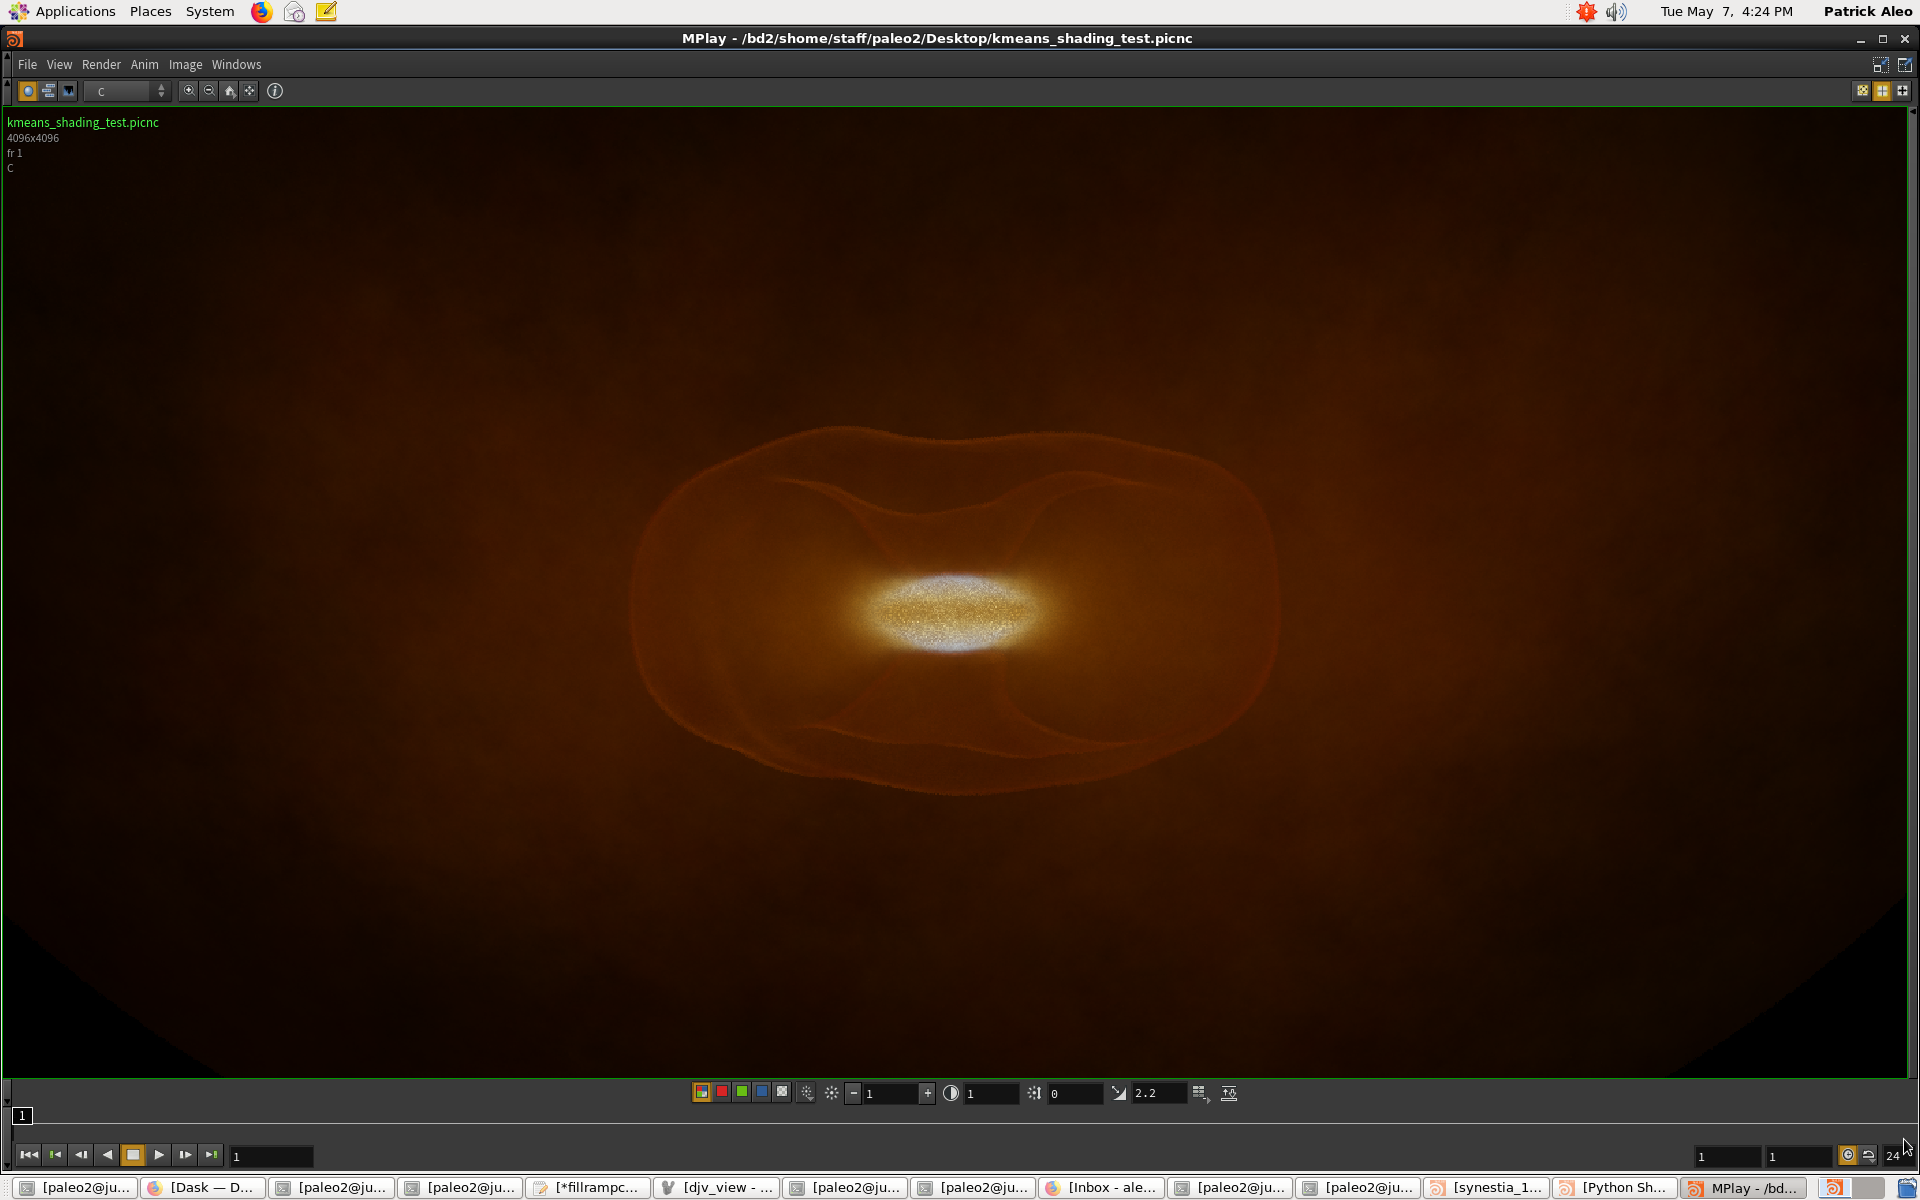

In [3]:
Image('shading_tests/kmeans_shading_test.png') 

> <h3> Mini-Batch Kmeans Final Render </h3>

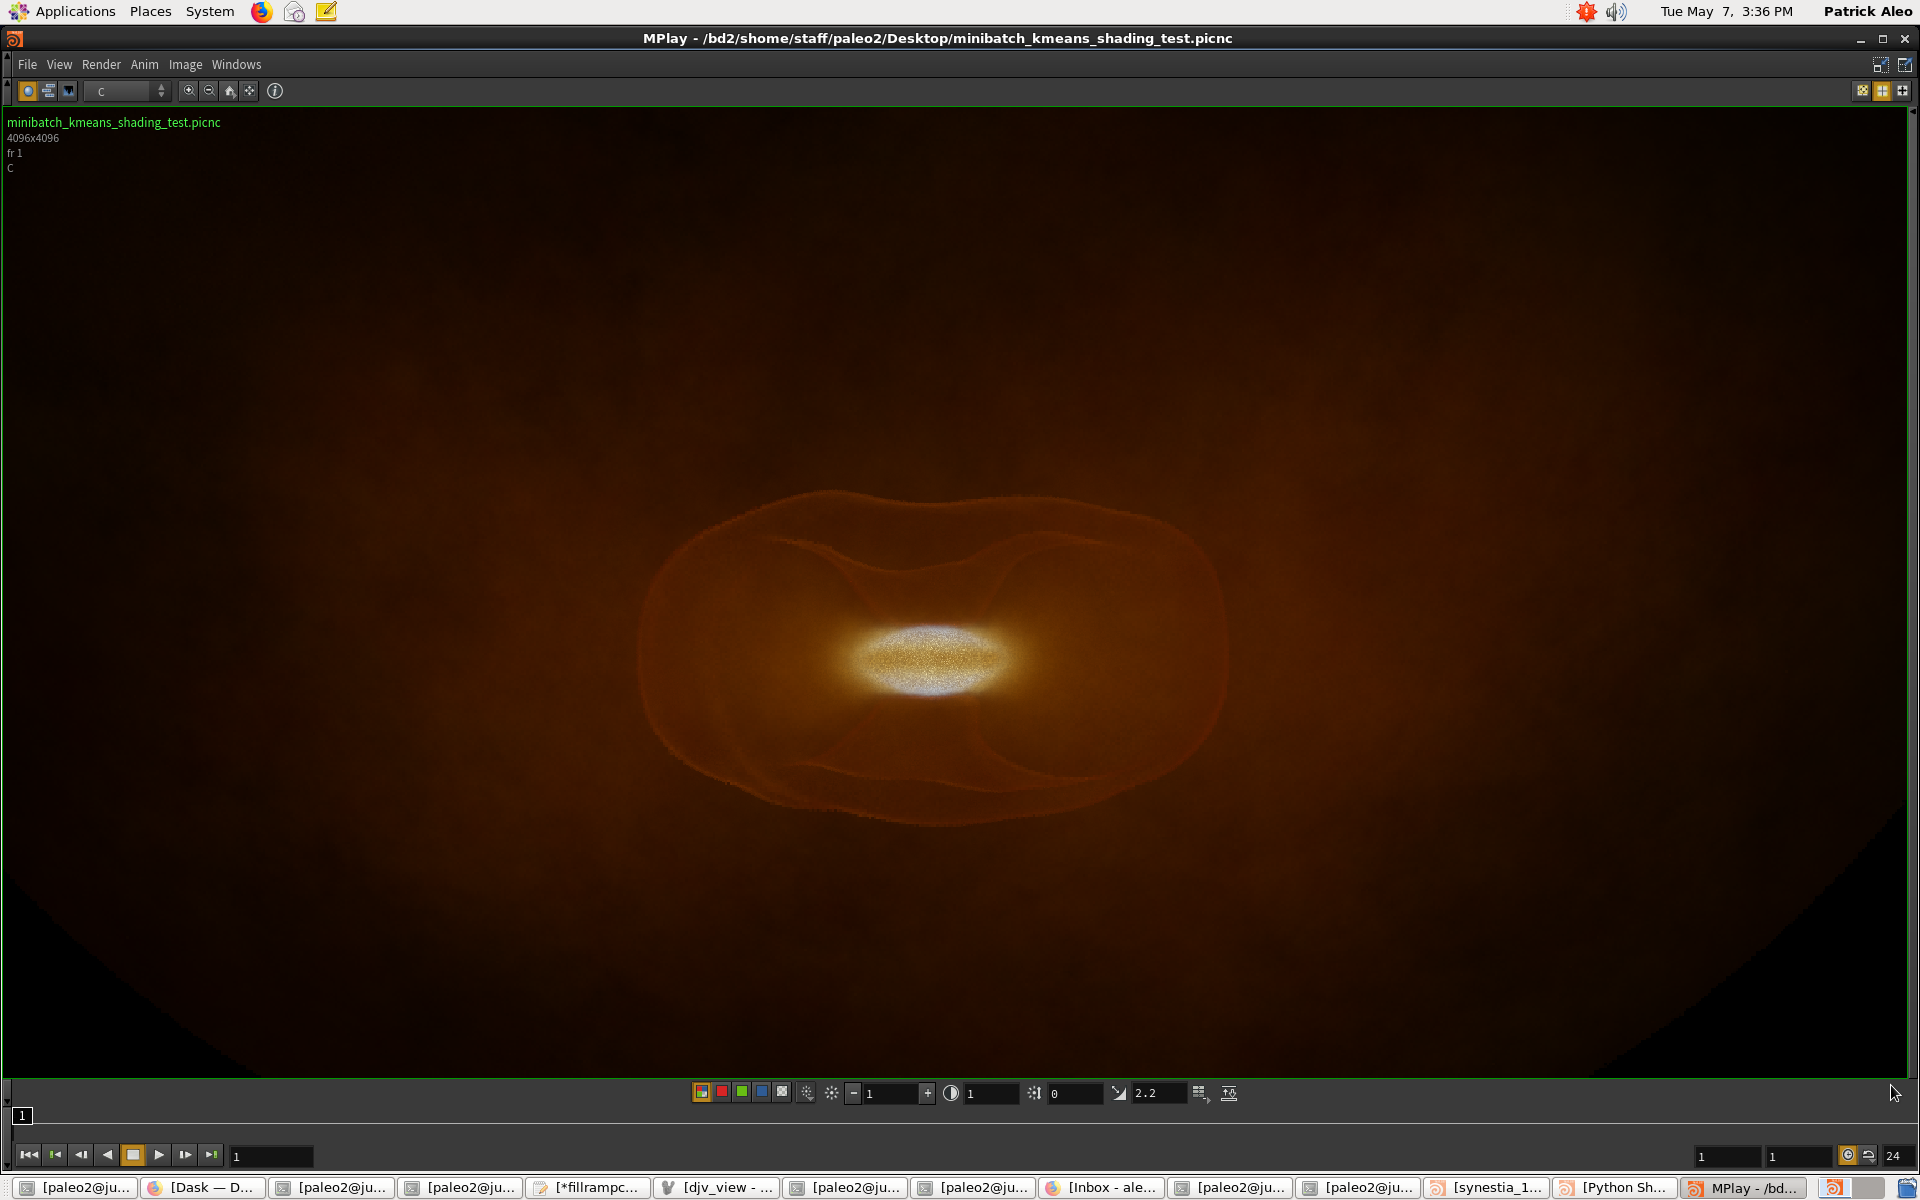

In [31]:
Image('shading_tests/minibatch_kmeans_shading_test.png') 

> <h3> DBSCAN Final Render </h3>

![](final_renders/Estra_dbscan_062119.jpg)

> <h3> GMM Final Render </h3>

![](final_renders/Estra_gmm_062119.jpg)

> <h3> VBGMM Final Render </h3>

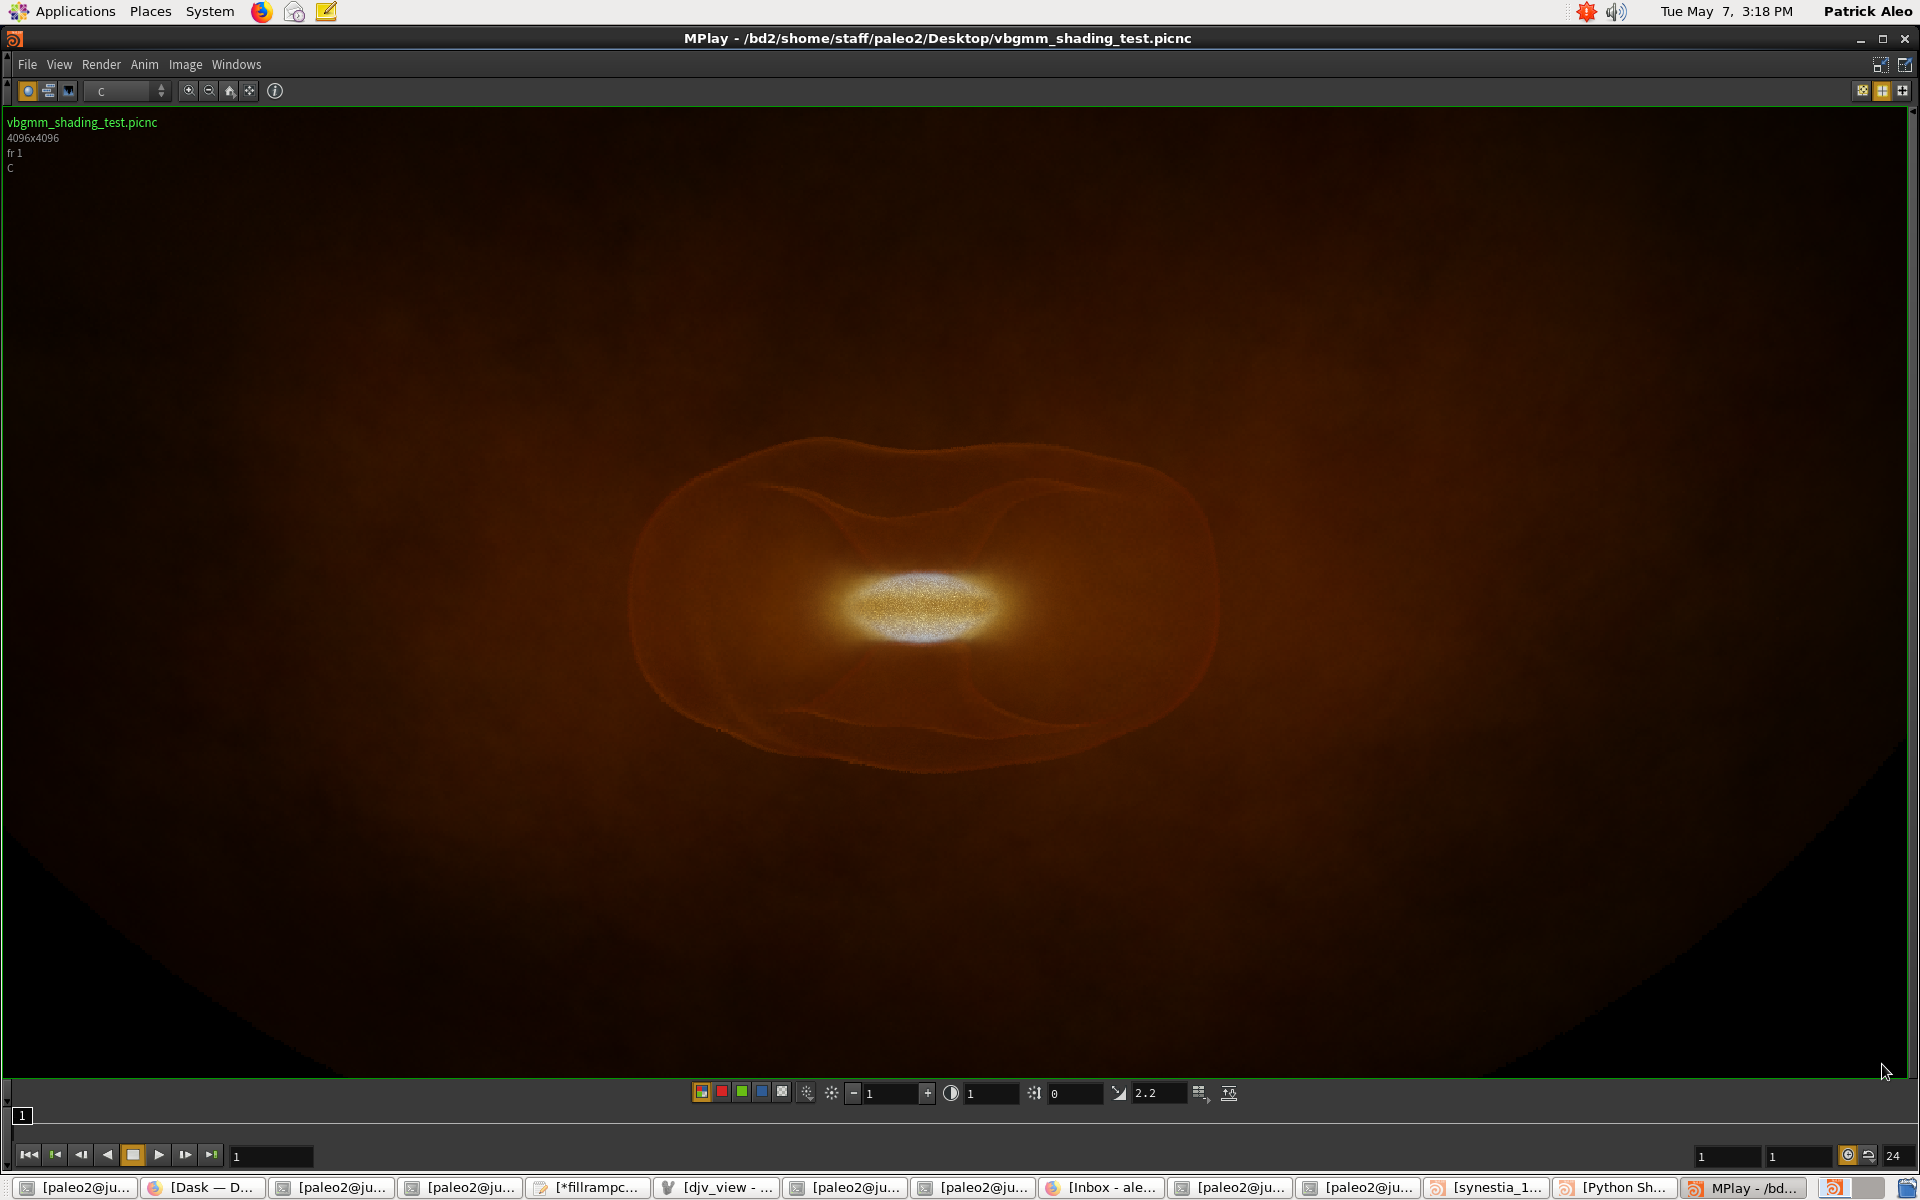

In [34]:
Image('shading_tests/vbgmm_shading_test.png') 